# Decentralised Optimisation with Graph Neural Networks and Edge AI

Name: Kevin Fastje  
Student ID: a1933491

## Assignment 3: Part C – Big Data Analysis

In [1]:
# Import necessary libraries
import pandas as pd
import os
import networkx as nx
from functools import reduce
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import torch
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import torch
from gcn_model import GCN, train_gcn
from sage_model import GraphSAGE, train_sage
from gat_model import GAT, train_gat
from evaluate_model import evaluate_model

import time, json, math
from torch.nn import L1Loss
from torch.optim import AdamW

torch.manual_seed(0)

# Set device for PyTorch
device = (
    torch.device("mps")  if torch.backends.mps.is_available()  else
    torch.device("cuda") if torch.cuda.is_available()          else
    torch.device("cpu")
)

print("Using", device)


/opt/anaconda3/envs/mbd/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/envs/mbd/lib/python3.11/site-packages/torch_scatter/_version_cpu.so, 0x0006): symbol not found in flat namespace '__ZN3c1017RegisterOperatorsD1Ev'
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/opt/anaconda3/envs/mbd/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/envs/mbd/lib/python3.11/site-packages/torch_cluster/_version_cpu.so, 0x0006): symbol not found in flat namespace '__ZN3c1017RegisterOperatorsD1Ev'
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/opt/anaconda3/envs/mbd/lib/python3.11/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disablin

Using mps


### 1. Data Pre-processing

In [2]:
# load data from part B
demand_df = pd.read_csv('/Users/kevin/Downloads/demand_data.csv')
energy_df      = pd.read_csv('/Users/kevin/Downloads/energy_data.csv', index_col=0)
distance_df    = pd.read_csv('/Users/kevin/Downloads/distance_data.csv', index_col=0)
eligibility_df = pd.read_csv('/Users/kevin/Downloads/eligibility_data.csv', index_col=0)


In [3]:
# Ensure all indices and columns are strings for consistency
eligibility_df.index = eligibility_df.index.astype(str)
eligibility_df.columns = eligibility_df.columns.astype(str)

distance_df.index = distance_df.index.astype(str)
distance_df.columns = distance_df.columns.astype(str)

In [4]:
# Set timeststamp as index for demand_df
demand_df = demand_df.set_index('timestamp')
# Sort the DataFrame by index (timestamp)
demand_df = demand_df.sort_index()

In [5]:
# Check the demand_df DataFrame
demand_df.head()
demand_df.info()
print('Index dtype:', demand_df.index.dtype)
print('Hours', len(demand_df))
print('Regions Example:', demand_df.columns[:5].tolist())

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 2050-01-01 00:00:00 to 2050-12-31 23:00:00
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DE11    8760 non-null   float64
 1   DE12    8760 non-null   float64
 2   DE13    8760 non-null   float64
 3   DE14    8760 non-null   float64
 4   DE21    8760 non-null   float64
 5   DE22    8760 non-null   float64
 6   DE23    8760 non-null   float64
 7   DE24    8760 non-null   float64
 8   DE25    8760 non-null   float64
 9   DE26    8760 non-null   float64
 10  DE27    8760 non-null   float64
 11  DE30    8760 non-null   float64
 12  DE40    8760 non-null   float64
 13  DE50    8760 non-null   float64
 14  DE60    8760 non-null   float64
 15  DE71    8760 non-null   float64
 16  DE72    8760 non-null   float64
 17  DE73    8760 non-null   float64
 18  DE80    8760 non-null   float64
 19  DE91    8760 non-null   float64
 20  DE92    8760 non-null   float64
 21  DE93    8

In [6]:
# # imports
# import pandas as pd
# from pathlib import Path
# import regional_optimiser as ropt

# # load demand and align timestamps
# demand_df = pd.read_csv('/Users/kevin/Downloads/demand_data.csv', index_col=0, parse_dates=True)
# demand_df['timestamp'] = pd.date_range('2050-01-01', periods=8760, freq='h')
# demand_df = demand_df.set_index('timestamp')

# # load energy data
# energy_df = pd.read_csv('/Users/kevin/Downloads/energy_data.csv', parse_dates=['timestamp'])

# # process yearly data
# all_results = []

# for year in range(2000, 2020):
#     print(f'🔧 Processing year {year} …')

#     # filter energy data for current year
#     energy_y = energy_df[energy_df['timestamp'].dt.year == year].copy()

#     # reshape energy data to long format
#     energy_long = energy_y.melt(
#         id_vars=['timestamp', 'region'],
#         value_vars=['pv', 'wind_onshore', 'wind_offshore'],
#         var_name='tech',
#         value_name='cf'
#     )

#     # pivot to wide format with multi-index columns
#     energy = energy_long.pivot_table(
#         index='timestamp',
#         columns=['tech', 'region'],
#         values='cf'
#     )

#     # align index with demand timestamps
#     energy.index = demand_df.index

#     # optimise regional mix
#     regional_mix_df = ropt.optimise_region_mix(energy, demand_df)
#     regional_mix_df['year'] = year

#     # store result
#     all_results.append(regional_mix_df)

# # concatenate all years
# labels_df = pd.concat(all_results)

# # reorder columns and export
# labels_df = labels_df[['region', 'pv', 'wind_onshore', 'wind_offshore', 'year']]
# labels_df.to_csv('regional_labels_all_years.csv', index=False)
# print('Saved results to regional_labels_all_years.csv')


In [7]:
# Load regional labels created by gurobi optimisation
labels_df = pd.read_csv('regional_labels_all_years.csv', index_col=0)

In [8]:
# inspect labels
labels_df.head()
labels_df['year'].unique()[:5]
print('Columns:', labels_df.columns.tolist())
print('Number of Rows:', len(labels_df))

Columns: ['pv', 'wind_onshore', 'wind_offshore', 'year']
Number of Rows: 760


In [9]:
# Check the index of the labels_df DataFrame
print(labels_df.index[:5])
print('Index name:', labels_df.index.name)

Index(['DE11', 'DE12', 'DE13', 'DE14', 'DE21'], dtype='object', name='region')
Index name: region


In [10]:
# eligibility inspection
print('Shape:', eligibility_df.shape)
print('Index name:', eligibility_df.index.name)
print('Example columns:', eligibility_df.columns[:5].tolist())
print('Example values:\n', eligibility_df.iloc[:3, :3])

Shape: (38, 38)
Index name: None
Example columns: ['DE11', 'DE12', 'DE13', 'DE14', 'DE21']
Example values:
       DE11  DE12  DE13
DE11     0     1     0
DE12     1     0     1
DE13     0     1     0


In [11]:
# distance_df inspection
print('Shape:', distance_df.shape)
print('Index name:', distance_df.index.name)
print('Example columns:', distance_df.columns[:5].tolist())
print('Example values:', distance_df.iloc[:3, :3])


Shape: (38, 38)
Index name: index
Example columns: ['DE11', 'DE12', 'DE13', 'DE14', 'DE21']
Example values:          DE11    DE12    DE13
index                        
DE11     0.00   68.99  151.48
DE12    68.99    0.00  114.90
DE13   151.48  114.90    0.00


In [12]:
# scale mean demand
demand = demand_df.mean().to_frame(name='mean_demand')
scaler = StandardScaler()
demand['mean_demand'] = scaler.fit_transform(demand[['mean_demand']])
demand.head()

,mean_demand
DE11,1.183716
DE12,0.350520
DE13,-0.029338
DE14,-0.352661
DE21,2.032245


In [13]:
demand_df.head()


,DE11,DE12,DE13,DE14,DE21,DE22,DE23,DE24,DE25,DE26,...,DEB1,DEB2,DEB3,DEC0,DED2,DED4,DED5,DEE0,DEF0,DEG0
timestamp,,,,,,,,,,,,,,,,,,,,,
2050-01-01 00:00:00,3.237,2.329,1.884,1.546,4.780,1.108,0.992,0.768,1.336,1.052,...,1.079,0.445,3.221,1.081,1.304,0.937,1.254,3.540,2.336,1.354
2050-01-01 01:00:00,3.189,2.289,1.852,1.532,4.704,1.091,0.981,0.761,1.300,1.042,...,1.068,0.443,3.146,1.078,1.282,0.929,1.219,3.473,2.285,1.336
2050-01-01 02:00:00,3.101,2.234,1.803,1.495,4.589,1.068,0.958,0.738,1.256,1.015,...,1.045,0.433,3.154,1.069,1.253,0.903,1.204,3.480,2.223,1.297
2050-01-01 03:00:00,3.059,2.214,1.784,1.477,4.549,1.058,0.946,0.727,1.236,1.000,...,1.034,0.430,3.152,1.071,1.234,0.887,1.195,3.468,2.184,1.277
2050-01-01 04:00:00,3.042,2.209,1.766,1.468,4.511,1.045,0.933,0.716,1.217,0.988,...,1.024,0.427,3.085,1.062,1.213,0.874,1.173,3.386,2.137,1.256


In [14]:
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 2050-01-01 00:00:00 to 2050-12-31 23:00:00
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DE11    8760 non-null   float64
 1   DE12    8760 non-null   float64
 2   DE13    8760 non-null   float64
 3   DE14    8760 non-null   float64
 4   DE21    8760 non-null   float64
 5   DE22    8760 non-null   float64
 6   DE23    8760 non-null   float64
 7   DE24    8760 non-null   float64
 8   DE25    8760 non-null   float64
 9   DE26    8760 non-null   float64
 10  DE27    8760 non-null   float64
 11  DE30    8760 non-null   float64
 12  DE40    8760 non-null   float64
 13  DE50    8760 non-null   float64
 14  DE60    8760 non-null   float64
 15  DE71    8760 non-null   float64
 16  DE72    8760 non-null   float64
 17  DE73    8760 non-null   float64
 18  DE80    8760 non-null   float64
 19  DE91    8760 non-null   float64
 20  DE92    8760 non-null   float64
 21  DE93    8

#### Graph Data

In [15]:
# imports and base graph
regions = sorted(labels_df.index.unique())

elig_mat = torch.tensor(eligibility_df.loc[regions, regions].values, dtype=torch.float)
edge_index, _ = dense_to_sparse(elig_mat)

dist_mat = distance_df.loc[regions, regions].values
edge_attr = torch.tensor(1.0 / dist_mat[elig_mat.numpy() == 1], dtype=torch.float).unsqueeze(1)

In [16]:
# monthly mean demand
demand_df.index = pd.to_datetime(demand_df.index)
demand_month = (demand_df
    .assign(month=demand_df.index.month)
    .groupby('month')
    .mean()
    .T)

scaler = StandardScaler()
demand_month_std = pd.DataFrame(
    scaler.fit_transform(demand_month.values),
    index=demand_month.index,
    columns=demand_month.columns
)

In [17]:
print(demand_df.columns)

Index(['DE11', 'DE12', 'DE13', 'DE14', 'DE21', 'DE22', 'DE23', 'DE24', 'DE25',
       'DE26', 'DE27', 'DE30', 'DE40', 'DE50', 'DE60', 'DE71', 'DE72', 'DE73',
       'DE80', 'DE91', 'DE92', 'DE93', 'DE94', 'DEA1', 'DEA2', 'DEA3', 'DEA4',
       'DEA5', 'DEB1', 'DEB2', 'DEB3', 'DEC0', 'DED2', 'DED4', 'DED5', 'DEE0',
       'DEF0', 'DEG0'],
      dtype='object')


In [18]:
# build data objects
energy_df['timestamp'] = pd.to_datetime(energy_df['timestamp'])
data_list = []

for year in range(2000, 2020):
    e_y = energy_df[energy_df['timestamp'].dt.year == year].copy()
    e_y['month'] = e_y['timestamp'].dt.month

    cf_month = (e_y
        .melt(id_vars=['month', 'region'],
              value_vars=['pv', 'wind_onshore', 'wind_offshore'],
              var_name='tech', value_name='cf')
        .groupby(['month', 'region', 'tech'])['cf']
        .mean()
        .unstack()
        .rename(columns={
            'pv': 'mean_pv_cf',
            'wind_onshore': 'mean_wind_onshore_cf',
            'wind_offshore': 'mean_wind_offshore_cf'})
    )

    y_mat = labels_df[labels_df['year'] == year].loc[regions, ['pv', 'wind_onshore', 'wind_offshore']]
    y = torch.tensor(y_mat.values, dtype=torch.float)

    for m in range(1, 13):
        cf_feat = cf_month.loc[m].loc[regions]
        demand_m = demand_month_std.loc[regions, m].to_frame('mean_demand')
        feats_df = cf_feat.join(demand_m)

        x = torch.tensor(feats_df.values, dtype=torch.float)

        data = Data(
            x=x,
            y=y,
            edge_index=edge_index,
            edge_attr=edge_attr
        )
        data.year = year
        data.month = m
        data_list.append(data)


In [19]:
# check result
print('Number of data objects:', len(data_list))
print('First example:', data_list[0])

Number of data objects: 240
First example: Data(x=[38, 4], edge_index=[2, 172], edge_attr=[172, 1], y=[38, 3], year=2000, month=1)


In [20]:
print(energy_df.head())

            timestamp region   pv  wind_onshore  wind_offshore  month
0 2000-01-01 00:00:00   DE11  0.0         0.013          0.277      1
1 2000-01-01 01:00:00   DE11  0.0         0.018          0.283      1
2 2000-01-01 02:00:00   DE11  0.0         0.024          0.269      1
3 2000-01-01 03:00:00   DE11  0.0         0.031          0.242      1
4 2000-01-01 04:00:00   DE11  0.0         0.036          0.215      1


### 2. Model Selection & Implementation

#### Split & DataLoader

In [21]:
# split by year
train_years = list(range(2000, 2016))
val_years   = [2016, 2017]
test_years  = [2018, 2019]

# data loaders
train_loader = DataLoader(
    [d for d in data_list if d.year in train_years],
    batch_size=4, shuffle=True
)

val_loader = DataLoader(
    [d for d in data_list if d.year in val_years],
    batch_size=2
)

test_loader = DataLoader(
    [d for d in data_list if d.year in test_years],
    batch_size=2
)


In [22]:
# Train the baseline model
def train_baseline(train_fn, model, loader, optimiser, loss_fn, device, epochs):
    for _ in range(epochs):
        train_fn(model, loader, optimiser, loss_fn, device, epochs=1)

# Evaluate the baseline model
def eval_baseline(model, loader, device):
    ys, preds = [], []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            ys.append(batch.y.cpu())
            preds.append(out.cpu())
    return evaluate_model(torch.cat(ys), torch.cat(preds))

#### GCN

In [23]:
# Configure and train the model
gcn = GCN(in_channels=4, hidden_layers=[256, 256], out_channels=3, dropout=0.2).to(device)
gcn_opt = torch.optim.AdamW(gcn.parameters(), lr=0.003, weight_decay=1e-4)

train_baseline(train_gcn, gcn, train_loader, gcn_opt, torch.nn.L1Loss(), device, epochs=300)
torch.save(gcn.state_dict(), 'gcn.pt')
print('GCN Validation:', eval_baseline(gcn, val_loader, device))

GCN Validation: {'MAE': 440.6896667480469, 'RMSE': 812.4923461177957, 'R2': -0.26004520058631897, 'MAPE': 110.67793303611934, 'MedianAE': 215.67552}


#### GraphSAGE

In [24]:
# Configure and train the model
sage = GraphSAGE(in_channels=4, hidden_layers=[256, 256], out_channels=3, dropout=0.2).to(device)
sage_opt = torch.optim.AdamW(sage.parameters(), lr=0.003, weight_decay=1e-4)

train_baseline(train_sage, sage, train_loader, sage_opt, torch.nn.L1Loss(), device, epochs=300)
torch.save(sage.state_dict(), "sage.pt")
print('GraphSAGE Validation:', eval_baseline(sage, val_loader, device))


GraphSAGE Validation: {'MAE': 447.3058776855469, 'RMSE': 817.6910709430549, 'R2': -0.25322461128234863, 'MAPE': 97.06780856206635, 'MedianAE': 207.51189}


#### GAT

In [25]:
# Configure and train the GAT model
gat = GAT(in_channels=4, hidden_layers=[32], out_channels=3, heads=8, dropout=0.2).to(device)
gat_opt = torch.optim.AdamW(gat.parameters(), lr=0.003, weight_decay=1e-4)

train_baseline(train_gat, gat, train_loader, gat_opt, torch.nn.L1Loss(), device, epochs=300)
torch.save(gat.state_dict(), "gat.pt")
print('GAT Validation:', eval_baseline(gat, val_loader, device))

GAT Validation: {'MAE': 435.4249572753906, 'RMSE': 815.1381784703744, 'R2': -0.26490041613578796, 'MAPE': 121.87060845199069, 'MedianAE': 214.76689}


### 3. Model Refinement & Hyperparameter Tuning

In [26]:
# Function to run an epoch of training
def train_one_epoch(model, loader, optimiser, loss_fn, device):
    model.train()
    epoch_loss = 0.0
    for batch in loader:
        batch = batch.to(device)
        optimiser.zero_grad()
        preds = model(batch.x, batch.edge_index)
        mask  = ~torch.isnan(batch.y).any(dim=1)
        loss  = loss_fn(preds[mask], batch.y[mask])
        loss.backward()
        optimiser.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

# Function for validation
@torch.no_grad()
def validate(model, loader, loss_fn, device):
    model.eval(); val = 0.0
    for batch in loader:
        batch = batch.to(device)
        preds = model(batch.x, batch.edge_index)
        mask  = ~torch.isnan(batch.y).any(dim=1)
        val  += loss_fn(preds[mask], batch.y[mask]).item()
    return val / len(loader)


In [27]:
def run_grid(model_cls, param_grid, train_loader, val_loader,
             max_epochs=150, patience=15, base_lr=3e-3, wd=1e-4,
             log_file=None):
    '''Returns (results_df, best_cfg).'''
    combos   = list(param_grid['model_args'])
    lr_list  = param_grid.get('lr', [base_lr])
    results  = []
    best_val = math.inf
    best_cfg = None
    t0_all   = time.time()

    for cfg in combos:
        for lr in lr_list:
            model = model_cls(**cfg).to(device)
            opt   = AdamW(model.parameters(), lr=lr, weight_decay=wd)
            loss_fn = L1Loss()

            counter = 0
            for ep in range(max_epochs):
                train_one_epoch(model, train_loader, opt, loss_fn, device)
                val_mae = validate(model, val_loader, loss_fn, device)

                if val_mae < best_val - 1e-3:
                    best_val, best_cfg = val_mae, {**cfg, 'lr': lr}
                    torch.save({'state': model.state_dict(), 'cfg': best_cfg},
                               f'best_{model_cls.__name__.lower()}.pt')
                    counter = 0
                else:
                    counter += 1
                if counter >= patience:
                    break

            run_id = (f'{model_cls.__name__}'
                      f'_d{len(cfg["hidden_layers"])}'
                      f'_h{cfg["hidden_layers"][0]}'
                      f'_p{int(cfg["dropout"]*100)}'
                      f'_lr{lr:.0e}')
            results.append({'run_id': run_id, **cfg, 'lr': lr,
                            'val_mae': round(val_mae, 2), 'epochs': ep+1})
            print(f'{run_id}: Val-MAE {val_mae:.2f}  ({ep+1} ep)')

    print(f'\nBest {model_cls.__name__}: {best_cfg} | MAE {best_val:.2f}'
          f' | grid time {time.time()-t0_all:.1f}s')

    df = pd.DataFrame(results).sort_values('val_mae')
    if log_file:
        df.to_csv(log_file, index=False)
    return df, best_cfg


In [28]:
# Learning rate common for all models
lr_common = [0.001, 0.003]

#### GCN

In [29]:
# GCN grid search configuration

gcn_grid = {
    'model_args': [
        {'in_channels':4, 'hidden_layers':[h]*d, 'out_channels':3, 'dropout':p}
        for d in (2,3) for h in (128,256) for p in (0.1,0.4)
    ],
    'lr': lr_common,
}

In [30]:
# Run GCN grid search
df_gcn,  best_gcn  = run_grid(GCN,       gcn_grid,  train_loader, val_loader,
                              log_file='gcn_grid.csv')

GCN_d2_h128_p10_lr1e-03: Val-MAE 444.00  (21 ep)
GCN_d2_h128_p10_lr3e-03: Val-MAE 446.50  (17 ep)
GCN_d2_h128_p40_lr1e-03: Val-MAE 439.99  (15 ep)
GCN_d2_h128_p40_lr3e-03: Val-MAE 446.61  (17 ep)
GCN_d2_h256_p10_lr1e-03: Val-MAE 444.55  (15 ep)
GCN_d2_h256_p10_lr3e-03: Val-MAE 445.62  (15 ep)
GCN_d2_h256_p40_lr1e-03: Val-MAE 444.17  (15 ep)
GCN_d2_h256_p40_lr3e-03: Val-MAE 448.53  (15 ep)
GCN_d3_h128_p10_lr1e-03: Val-MAE 436.31  (15 ep)
GCN_d3_h128_p10_lr3e-03: Val-MAE 440.68  (15 ep)
GCN_d3_h128_p40_lr1e-03: Val-MAE 437.80  (15 ep)
GCN_d3_h128_p40_lr3e-03: Val-MAE 437.81  (15 ep)
GCN_d3_h256_p10_lr1e-03: Val-MAE 435.54  (15 ep)
GCN_d3_h256_p10_lr3e-03: Val-MAE 438.40  (15 ep)
GCN_d3_h256_p40_lr1e-03: Val-MAE 437.20  (15 ep)
GCN_d3_h256_p40_lr3e-03: Val-MAE 445.45  (15 ep)

Best GCN: {'in_channels': 4, 'hidden_layers': [128, 128], 'out_channels': 3, 'dropout': 0.4, 'lr': 0.003} | MAE 417.85 | grid time 164.9s


#### GraphSAGE

In [31]:
# GraphSAGE grid search configuration
sage_grid = {
    'model_args': [
        {'in_channels':4, 'hidden_layers':[h]*2, 'out_channels':3,
         'dropout':p, 'aggr':a}
        for a in ('mean','max') for h in (128,256) for p in (0.1,0.4)
    ],
    'lr': lr_common,
}


In [32]:
# Run GraphSAGE grid search
df_sage, best_sage = run_grid(GraphSAGE, sage_grid, train_loader, val_loader,
                              log_file='sage_grid.csv')

GraphSAGE_d2_h128_p10_lr1e-03: Val-MAE 426.87  (46 ep)
GraphSAGE_d2_h128_p10_lr3e-03: Val-MAE 426.51  (32 ep)
GraphSAGE_d2_h128_p40_lr1e-03: Val-MAE 435.27  (15 ep)
GraphSAGE_d2_h128_p40_lr3e-03: Val-MAE 420.40  (15 ep)
GraphSAGE_d2_h256_p10_lr1e-03: Val-MAE 433.81  (15 ep)
GraphSAGE_d2_h256_p10_lr3e-03: Val-MAE 421.85  (15 ep)
GraphSAGE_d2_h256_p40_lr1e-03: Val-MAE 433.51  (15 ep)
GraphSAGE_d2_h256_p40_lr3e-03: Val-MAE 431.98  (26 ep)
GraphSAGE_d2_h128_p10_lr1e-03: Val-MAE 424.78  (15 ep)
GraphSAGE_d2_h128_p10_lr3e-03: Val-MAE 423.92  (15 ep)
GraphSAGE_d2_h128_p40_lr1e-03: Val-MAE 445.28  (15 ep)
GraphSAGE_d2_h128_p40_lr3e-03: Val-MAE 429.56  (15 ep)
GraphSAGE_d2_h256_p10_lr1e-03: Val-MAE 430.31  (15 ep)
GraphSAGE_d2_h256_p10_lr3e-03: Val-MAE 438.79  (19 ep)
GraphSAGE_d2_h256_p40_lr1e-03: Val-MAE 439.85  (15 ep)
GraphSAGE_d2_h256_p40_lr3e-03: Val-MAE 442.42  (15 ep)

Best GraphSAGE: {'in_channels': 4, 'hidden_layers': [256, 256], 'out_channels': 3, 'dropout': 0.1, 'aggr': 'max', 'lr':

#### GAT

In [33]:
# GAT grid search configuration
gat_grid = {
    'model_args': [
        {'in_channels':4, 'hidden_layers':[dim], 'out_channels':3,
         'heads':k, 'dropout':p}
        for (k,dim) in ((4,32),(8,16)) for p in (0.2,0.5)
    ],
    'lr': lr_common,
}


In [34]:
# Run GAT grid search
df_gat,  best_gat  = run_grid(GAT, gat_grid,  train_loader, val_loader,
                              log_file='gat_grid.csv')

GAT_d1_h32_p20_lr1e-03: Val-MAE 440.54  (46 ep)
GAT_d1_h32_p20_lr3e-03: Val-MAE 436.14  (27 ep)
GAT_d1_h32_p50_lr1e-03: Val-MAE 480.89  (15 ep)
GAT_d1_h32_p50_lr3e-03: Val-MAE 435.44  (15 ep)
GAT_d1_h16_p20_lr1e-03: Val-MAE 472.24  (15 ep)
GAT_d1_h16_p20_lr3e-03: Val-MAE 444.79  (15 ep)
GAT_d1_h16_p50_lr1e-03: Val-MAE 474.98  (15 ep)
GAT_d1_h16_p50_lr3e-03: Val-MAE 443.43  (15 ep)

Best GAT: {'in_channels': 4, 'hidden_layers': [32], 'out_channels': 3, 'heads': 4, 'dropout': 0.2, 'lr': 0.003} | MAE 434.46 | grid time 108.3s


### 4. Performance Description and best model

In [36]:
# load logs
results = pd.concat([
    pd.read_csv('gcn_grid.csv').assign(model='GCN'),
    pd.read_csv('sage_grid.csv').assign(model='GraphSAGE'),
    pd.read_csv('gat_grid.csv').assign(model='GAT'),
])

/var/folders/sk/816rf7z11wb24jqhcn350qzh0000gn/T/ipykernel_99929/3584346781.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=best, x='model', y='val_mae', palette='Set2')


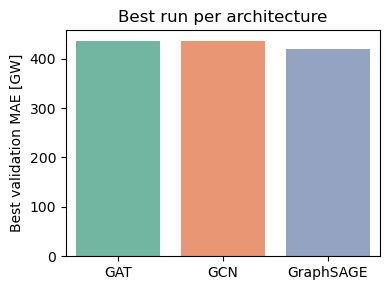

In [37]:

# bar chart of BEST run per model
best = results.sort_values('val_mae').groupby('model').first().reset_index()
plt.figure(figsize=(4,3))
sns.barplot(data=best, x='model', y='val_mae', palette='Set2')
plt.ylabel('Best validation MAE [GW]')
plt.xlabel('')
plt.title('Best run per architecture')
plt.tight_layout(); plt.savefig('best_bar.png', dpi=300)

/var/folders/sk/816rf7z11wb24jqhcn350qzh0000gn/T/ipykernel_99929/2409253481.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=results, x='model', y='val_mae', palette='Set2', inner='quartile')


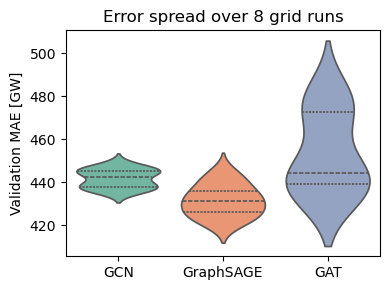

In [40]:
# violin plot: all runs
plt.figure(figsize=(4,3))
sns.violinplot(data=results, x='model', y='val_mae', palette='Set2', inner='quartile')
plt.ylabel('Validation MAE [GW]'); plt.xlabel('')
plt.title('Error spread over 8 grid runs')
plt.tight_layout(); plt.savefig('spread_violin.png', dpi=300)